# Predictive Modeling
Kunlun(Leo) Liu

# The objective of this project is to identify which indicators are the best predictors for user adoption.

In this project, the Python language is used (Python 3.6.0, Anaconda custom (64-bit)). The whole process is reproducible using the source code included with the submission.

# 1. Exploratory Data Analysis

## 1.1. Data Preparation and sanity check

The "adopted" variable is created using the createAdoption function as included in a separate "crate_adopted.py" file. First of all, import necessary packages and load the csv data:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
import calendar
import pytz
from sklearn.tree import export_graphviz
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import create_adopted as ca #import .py file to create adopted

In [2]:
#read in .csv files
visited = pd.read_csv("takehome_user_engagement-intern.csv")
users = pd.read_csv("takehome_users-intern.csv",encoding = "latin1")
print(visited.shape,users.shape)
users.head()

(207917, 3) (12000, 11)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,yahoo.com


Users data contains 12000 rows, and 11 columns. Some of the columns contain dates, and some contain strings and integers. We are not interested in "names" because it is unique. We also want to remove "email", we will use "email_domain" and manipulate it later. Let's remove "names" and "email":

In [3]:
#drop "name","email"
users = users.drop(["name","email"],axis=1)
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0,gustr.com
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,yahoo.com
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,yahoo.com


Next, let's import create_adopted.py to generate new variables. This function returns a dataframe with 3 columns. This first column is user_id, the second column is "adopted" that indicates whether a user is adopted (1 means adopted, 0 means not adopted), the third column is "login_frequency" that represents the times that a user had logged in. Then we join it with users dataset by object_id. We define an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period. 

In [4]:
target = ca.create(visited,3,6) # run create function in create_adopted.py
data = pd.merge(target,users,how="inner",left_on="user_id",right_on="object_id")
data = data.drop(["user_id"],axis=1) # drop user_id since it is the same with objecti_id
print(data.shape)
data.head()

(8823, 11)


,adopted,login_frequency,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain
0,0,1,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com
1,1,14,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com
2,0,1,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0,gustr.com
3,0,1,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,yahoo.com
4,0,1,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,yahoo.com


Sanity check on the data in terms of missing values, duplicated rows, and unreasonable values:

In [5]:
completeness = data.count().sort_values() * 100 / len(data)
print(completeness)

invited_by_user_id             54.131248
adopted                       100.000000
login_frequency               100.000000
object_id                     100.000000
creation_time                 100.000000
creation_source               100.000000
last_session_creation_time    100.000000
opted_in_to_mailing_list      100.000000
enabled_for_marketing_drip    100.000000
org_id                        100.000000
email_domain                  100.000000
dtype: float64


Only column inveted_by_user_id contains missing values.

In [6]:
# Are there duplicated rows
duplicate_index = data.duplicated(keep=False)
print('Duplicated rows: ' + str(sum(duplicate_index)))
print(data[duplicate_index].sort_values(by=list(data.columns)))

Duplicated rows: 0
Empty DataFrame
Columns: [adopted, login_frequency, object_id, creation_time, creation_source, last_session_creation_time, opted_in_to_mailing_list, enabled_for_marketing_drip, org_id, invited_by_user_id, email_domain]
Index: []


Yeah! There are no duplicated rows.

# 1.2. Feature Engineering

By counting values of the email_domain, the frequency of each email_domain used as follows:

gmail.com         2930
yahoo.com         1726
jourrapide.com     883
gustr.com          842
cuvox.de           828
hotmail.com        803

Other email_domain just appear once or twice. Therefore, I categorized email_domain that used less than 800 times as "other".

In [7]:
value_count = data["email_domain"].value_counts()
data["email_domain"] = data["email_domain"].apply(lambda x:"other" if value_count[x] < 800 else x)

In the next step, I converted last_session_creation_time to UTC time. Then I subtracted creation_time from converted last_session_creation_time, I named this new column "duration" which represents how long a user has stayed active.

In [8]:
data["last_session_creation_time"] = data["last_session_creation_time"].apply(
    lambda x: dt.datetime.utcfromtimestamp(x).strftime('%Y-%m-%dT%H:%M:%SZ'))

data["creation_time"] = pd.to_datetime(data["creation_time"])
data["last_session_creation_time"] = pd.to_datetime(data["last_session_creation_time"])

data["duration"] = (data["last_session_creation_time"] - data["creation_time"]).apply(lambda x: x / pd.Timedelta('1 hour'))

#data = data.drop(["creation_time","last_session_creation_time"],axis=1)

data.head()

,adopted,login_frequency,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,duration
0,0,1,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,yahoo.com,0.0
1,1,14,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,gustr.com,3264.0
2,0,1,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,gustr.com,0.0
3,0,1,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,yahoo.com,24.0
4,0,1,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,yahoo.com,120.0


Then I converted creation_time to weekday, and categorized it whether the day that users created their account on "workday" or "weekend".

In [9]:
data["creation_time"] = data["creation_time"].apply(lambda x: calendar.day_name[x.weekday()])
data["Weekend"] = data["creation_time"].apply(lambda x: "weekend" if x == "Sunday" or x == "Saturday" else "workday")

In this step, I create a new column that represents the number of users from a specific organization.

In [10]:
value_count = data["org_id"].value_counts()

data["org_size"] = data["org_id"].apply(lambda x: value_count[x])

data = data.drop(["org_id"],axis=1)

data.head()

,adopted,login_frequency,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,email_domain,duration,Weekend,org_size
0,0,1,1,Tuesday,GUEST_INVITE,2014-04-22 03:53:30,1,0,10803.0,yahoo.com,0.0,workday,56
1,1,14,2,Friday,ORG_INVITE,2014-03-31 03:45:04,0,0,316.0,gustr.com,3264.0,workday,172
2,0,1,3,Tuesday,ORG_INVITE,2013-03-19 23:14:52,0,0,1525.0,gustr.com,0.0,workday,23
3,0,1,4,Tuesday,GUEST_INVITE,2013-05-22 08:09:28,0,0,5151.0,yahoo.com,24.0,workday,172
4,0,1,5,Thursday,GUEST_INVITE,2013-01-22 10:14:20,0,0,5240.0,yahoo.com,120.0,workday,11


Create dummy variables for creation_source, email_domain, and Weekend.

In [11]:
ddata = pd.get_dummies(data, columns=["creation_source","email_domain","Weekend"],drop_first=True)
ddata = ddata.drop(["creation_time","last_session_creation_time","object_id","invited_by_user_id"],axis=1)

ddata.head()

,adopted,login_frequency,opted_in_to_mailing_list,enabled_for_marketing_drip,duration,org_size,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_domain_gmail.com,email_domain_gustr.com,email_domain_hotmail.com,email_domain_jourrapide.com,email_domain_other,email_domain_yahoo.com,Weekend_workday
0,0,1,1,0,0.0,56,0,0,0,0,0,0,0,0,0,1,1
1,1,14,0,0,3264.0,172,1,0,0,0,0,1,0,0,0,0,1
2,0,1,0,0,0.0,23,1,0,0,0,0,1,0,0,0,0,1
3,0,1,0,0,24.0,172,0,0,0,0,0,0,0,0,0,1,1
4,0,1,0,0,120.0,11,0,0,0,0,0,0,0,0,0,1,1


# 1.3. Exploratory Analysis

In this section, I will check the feature value distribution, and feature correlation. First let's define two functions that plot feature value distribution and plot one against another:

In [12]:
# Plot values distribution and box plot
def plot_distribution(series):
    if series.dtype.name == 'category':
        fig = plt.figure()
        order = series.value_counts().sort_values().index
        ax = sns.countplot(series, order=order)
        for p in ax.patches:
            x = p.get_bbox().get_points()[:, 0]
            y = p.get_bbox().get_points()[1, 1]
            ax.annotate('{:.1f}%'.format(100. * y / len(series)), (x.mean(), y), ha='center', va='bottom')
    else:
        fig, axes = plt.subplots(1, 2, figsize=(9,4))
        series.plot.box(ax = axes[0], sym='k.')
        # sns.boxplot(series, ax=axes[0], vert=True)
        series.plot.hist(bins = 100, ax = axes[1], color = 'blue')
        axes[0].set_ylabel("")
        axes[1].set_xlabel("")
        plt.show()

# Plot a feature against another
def feature_vs_feature(data, feature, target):
    df = data.copy()
    df[target] = [target + ': ' + str(val) for val in df[target]]
    fig = plt.figure(figsize=(10,6))
    # sns.jointplot(x=feature, y=label, kind='reg', data=data)
    categories = df[target].unique()
    category_counts = df[target].value_counts()
    if df[feature].dtype.name == 'category':
        ax = sns.countplot(x=feature, data=df, hue=target)
        plt.legend(loc=1)
        count = 0
        bar_num = len(ax.patches)//len(categories)
        for p in (ax.patches):
            hue_index = count // bar_num
            x = p.get_bbox().get_points()[:, 0]
            y = p.get_bbox().get_points()[1, 1]
            ax.annotate('{:.1f}%'.format(100. * y / category_counts[categories[hue_index]]), 
                        (x.mean(), y), ha='center', va='bottom')
            count += 1
    else:
        for category in categories:
            y = df[feature][df[target]==category]
            ax = sns.kdeplot(y, label=category)
            # ax = sns.distplot(y, label=category)
            ax.set_xlabel(feature)

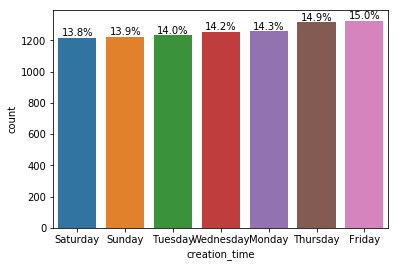

In [13]:
data["creation_time"] = data["creation_time"].astype('category')
plot_distribution(data["creation_time"])

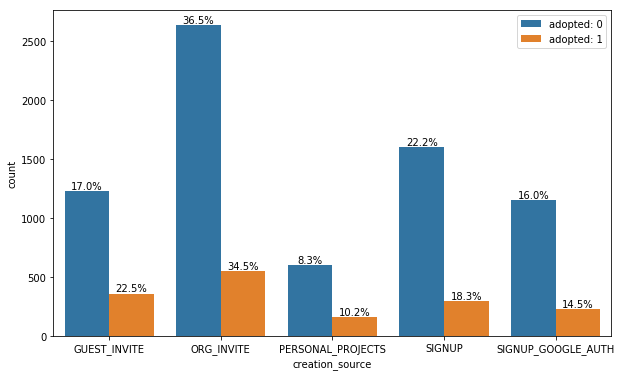

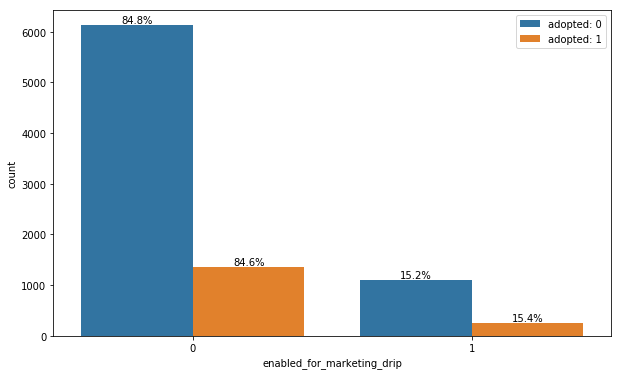

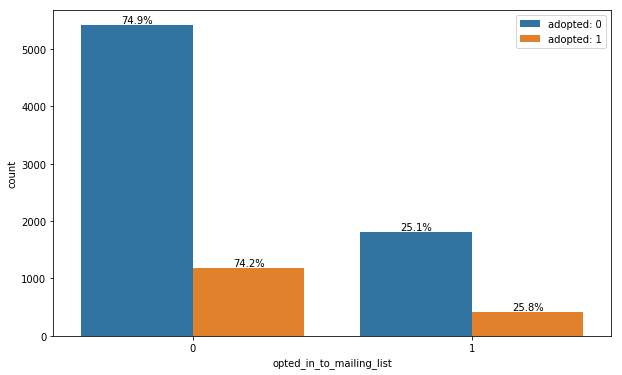

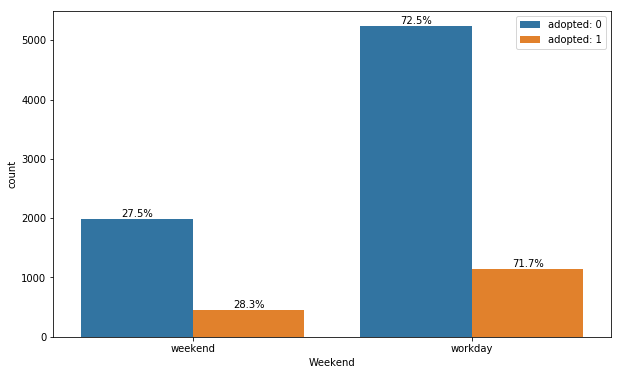

In [14]:
data["creation_source"] = data["creation_source"].astype('category')
feature_vs_feature(data,"creation_source","adopted")

data["enabled_for_marketing_drip"] = data["enabled_for_marketing_drip"].astype('category')
feature_vs_feature(data,"enabled_for_marketing_drip","adopted")

data["opted_in_to_mailing_list"] = data["opted_in_to_mailing_list"].astype('category')
feature_vs_feature(data,"opted_in_to_mailing_list","adopted")

data["Weekend"] = data["Weekend"].astype('category')
feature_vs_feature(data,"Weekend","adopted")

Feature correlation with adopted:
enabled_for_marketing_drip            0.002058
opted_in_to_mailing_list              0.006650
email_domain_gmail.com                0.006865
creation_source_SIGNUP_GOOGLE_AUTH    0.015741
creation_source_ORG_INVITE            0.015820
creation_source_PERSONAL_PROJECTS     0.026429
creation_source_SIGNUP                0.036937
email_domain_yahoo.com                0.038832
email_domain_hotmail.com              0.052336
org_size                              0.097820
login_frequency                       0.636508
duration                              0.787326
adopted                               1.000000
Name: adopted, dtype: float64


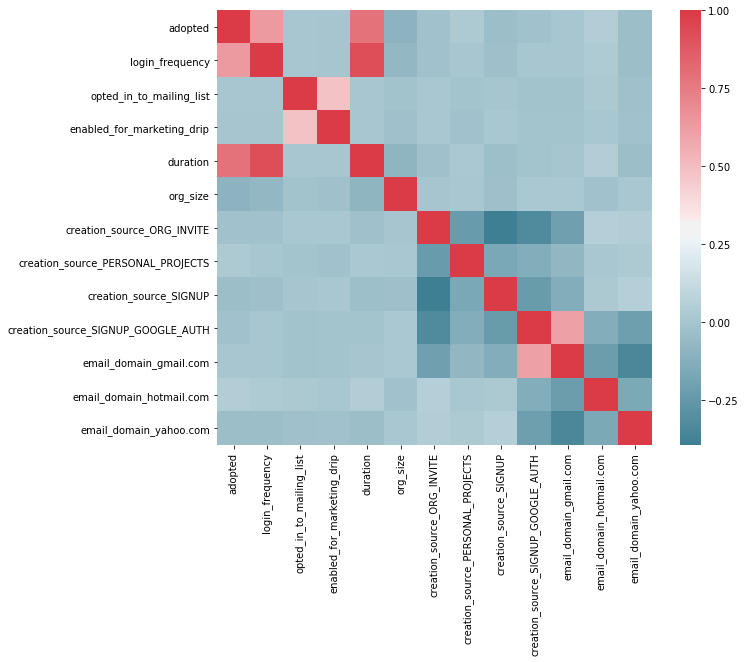

In [15]:
print("Feature correlation with adopted:")
def plot_correlation(df):
    f, ax = plt.subplots(figsize=(10, 8))
    corr = df.corr()
    print(abs(corr['adopted']).sort_values())
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)

    
ddata = ddata.drop(["email_domain_other"],axis=1)
ddata = ddata.drop(["email_domain_jourrapide.com"],axis=1)
ddata = ddata.drop(["email_domain_gustr.com"],axis=1)
ddata = ddata.drop(["Weekend_workday"],axis=1)

plot_correlation(ddata)

The heatmap shows that login_frequency and adopted has strong correlation. Duration has strong correlation with both login_frequency and adopted. Also, enabled_for_marketing_drip and gmail.com have strong correlation with adopted. It indicates that these features would be important predictors for future adoption. 

# 2. Building Predictive Models

## 2.1. Extreme Gradient Boosting

In this part, three models were used: Extreme Gradient Boosting (XGBoost), Logistic Regression and Decision Tree. XGBoost can learn non-linear relationship between features and target, require minimum feature preprocessing, and can report feature importance. Logistic Regression picks up linear correlation between log odd and features, and we can use its coefficients to assess feature importance. Using multiple models can help better verify the effects of our features on the target. By combining feature importance from diverse models, we can have a better understanding on how these factors affect future adoption. Decision Tree was used just to see how continuous variables are splitted.

In [16]:
#split predictors and response
target = ddata.iloc[:,0]
train = ddata.iloc[:,1:]
train.shape

(8823, 12)

In [17]:
# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2),
#     "n_estimators":[58,60,62,64]#range(1,100,5)

# }
# param_test2 = {
#  'subsample':range(0,1),
#  'colsample_bytree':range(0,1),
# }

# param_test3 = {
#  'gamma':[i/10.0 for i in range(0,5)]
# }

# param_test4 = {
#  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# }

# param_test5 = {
#  'learning_rate':[0.01,0.03,0.05,0.07,0.09,0.1]
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=81, max_depth=3,
#  min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch1.fit(train,target)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

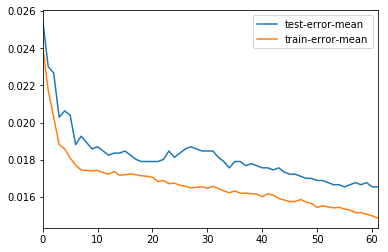

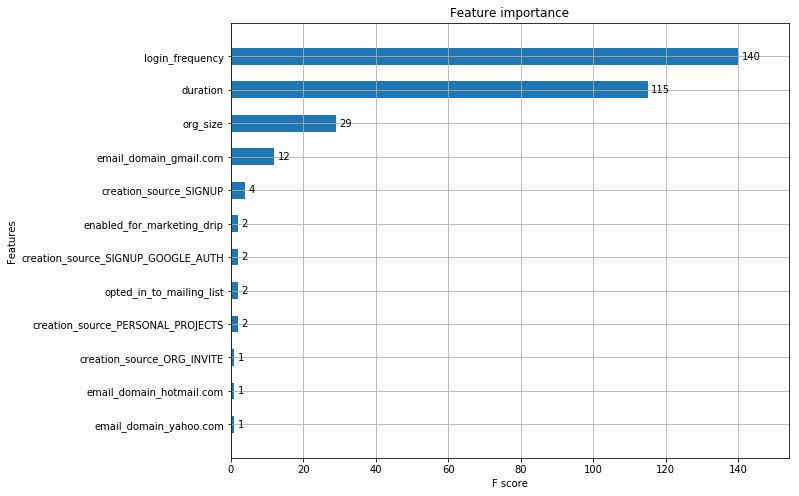

In [18]:
dtrain = xgb.DMatrix(train, target)
# Define parameters
xgb_params = {
    'n_estimators': 62,
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'gamma': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'silent': 1,
    'reg_alpha': 0.01,
    'seed': 8
}
# plot the training and testing errors as the number of estimators increase
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=xgb_params['n_estimators'], nfold=5,
                          metrics=['auc', 'error'], early_stopping_rounds=50)
cv_output[['test-error-mean', 'train-error-mean']].plot()
# cv_output[['test-auc-mean', 'train-auc-mean']].plot()
num_boost_rounds = len(cv_output)

# Train a model and plot feature importance
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)


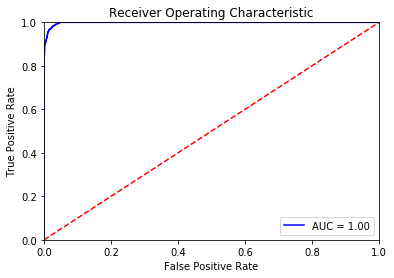

In [19]:
# Create a function that gives ROC analysis and plots ROC curve
model = XGBClassifier(learning_rate =0.1,
                      n_estimators=62, 
                      max_depth=3,
                      min_child_weight=1, 
                      gamma=0.3,
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      nthread=4, 
                      scale_pos_weight=1, 
                      seed=27)

def roc_analysis(y_true, y_score):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
    # pos_label specifies what label is considered positive
    roc_auc = metrics.auc(fpr, tpr)
    youden_index = tpr - fpr
    index = np.argmax(youden_index)
    cutoff = thresholds[index]
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=42)

model.fit(X_train, y_train)
pred = [item[1] for item in model.predict_proba(X_test)]
roc_analysis(y_test, pred)

In [20]:
# Train the model with part of the data, perform prediction on the rest
pred = model.predict(X_test)
conf = confusion_matrix(y_test, pred)
conf = pd.DataFrame(data=conf, columns=['Pred Not Adopted', 'Pred Adopted'], index=['True Not Adopted', 'True Adopted'])
print(conf)

                  Pred Not Adopted  Pred Adopted
True Not Adopted              2348            25
True Adopted                    28           511


# 2.2. Logistic Regression

In [21]:
# A function to cross-validate.
def cross_validation(model, train, target, fold=5):
    # Get a cross validation iterator, with stratified shuffle
    cv = StratifiedKFold(n_splits=fold, random_state=0)
    scores = cross_val_score(model, train, target, cv=cv)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.01)


Text(0.5,1,'Feature coefficients')

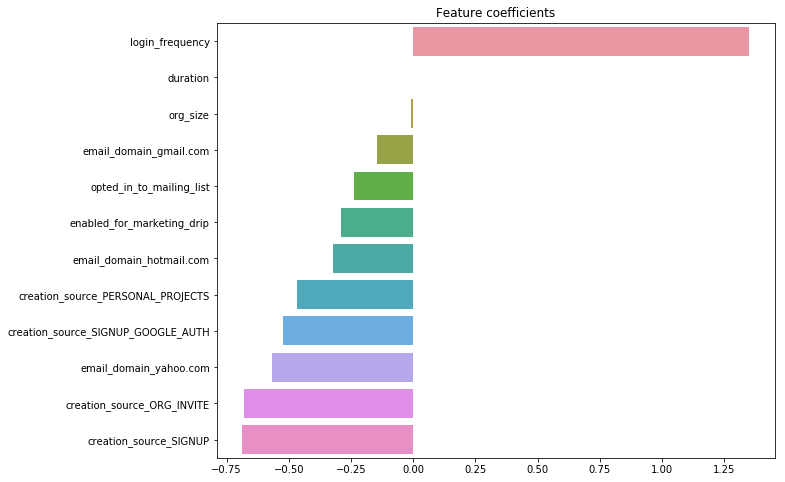

In [22]:
#train a logistic regression model
lr = LogisticRegression(random_state=3, penalty='l2',class_weight='balanced')
cross_validation(lr, train, target)

lr.fit(train, target)
coeff = pd.Series(data=lr.coef_[0], index=train.columns)
coeff = (coeff).sort_values(ascending=False)
fig = plt.figure(figsize=(10,8))
sns.barplot(x=coeff.values, y=coeff.index)
plt.title("Feature coefficients")

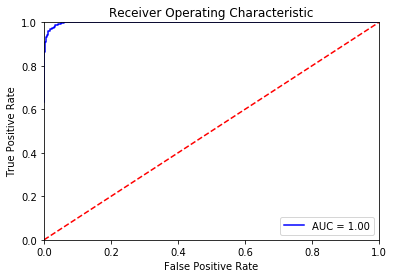

In [23]:
# Create a function that gives ROC analysis and plots ROC curve
lr.fit(X_train, y_train)
pred = [item[1] for item in lr.predict_proba(X_test)]
roc_analysis(y_test, pred)

In [24]:
# Train the model with part of the data, perform prediction on the rest
pred = lr.predict(X_test)
conf = confusion_matrix(y_test, pred)
conf = pd.DataFrame(data=conf, columns=['Pred Not Adopted', 'Pred Adopted'], index=['True Not Adopted', 'True Adopted'])
print(conf)

                  Pred Not Adopted  Pred Adopted
True Not Adopted              2322            51
True Adopted                    16           523


# 2.3. Decision Tree

In [25]:
# train a simple decision tree classifier to see how login_frequency and duration is splitted
dt = tree.DecisionTreeClassifier(max_depth=3)
dt.fit(train,target)
cross_val_score(dt, train, target, cv=10,scoring='accuracy').mean()

0.98028083289534407

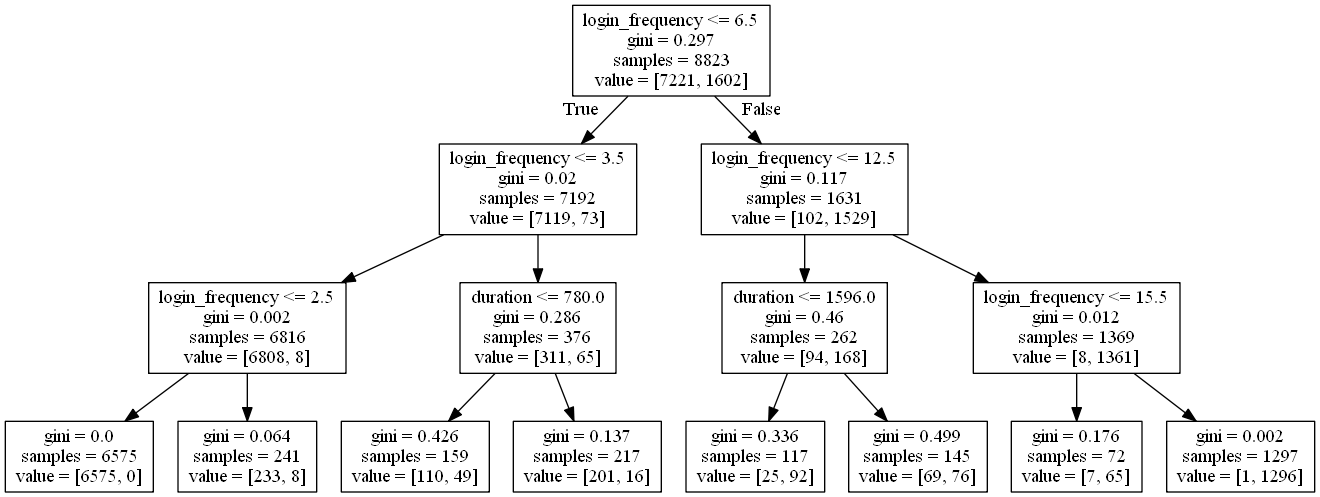

In [26]:
#graph tree 
export_graphviz(dt, out_file='tree.dot',feature_names=train.columns)

!dot -Tpng tree.dot > tree.png
Image(filename='tree.png')